In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
from datetime import datetime, timedelta
import pandas as pd
import math
import numpy as np
import random
from tqdm import trange

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

from math import sqrt
from scipy import stats

import matplotlib
# matplotlib.use('TkAgg')  # Switch to the TkAgg backend
import matplotlib.pyplot as plt
import datetime as dt

import torch
import torch.nn as nn
import time

import seaborn as sns

from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib.pyplot import figure
from itertools import cycle

pd.options.display.max_columns=50

plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [2]:
 def batch_norm(data, batches):
        
        if batches <= 0:
            raise ValueError("Number of parts (x) must be greater than 0.")
    
        part_length = len(data) // batches
        remainder = len(data) % batches
        start_index = 0
        batch_lst = []
        
        for i in range(batches):
            end_index = start_index + part_length + (1 if i < remainder else 0)
            batch_lst.append(data[start_index:end_index])
            start_index = end_index
        
        means = []
        stdevs = []
        
        for i in range(batches):
            batch = batch_lst[i]
            mean = batch.mean(dim=1, keepdim=True)
            batch = batch - mean
            stdev = torch.sqrt(torch.var(batch, dim=1, keepdim=True, unbiased=False) + 1e-5)
            batch /= stdev
            means.append(mean)
            stdevs.append(stdev)
            batch_lst[i] = batch
            
        data = torch.cat(batch_lst, dim=0)
        
        return data

In [3]:
def tensor_batch_norm(data):
    for i in range(data.size(2)):
        data[:, :, i] = batch_norm(data[:, :, i], 1)
    return data

In [4]:
global save_path
name_sales = 'sales_train_evaluation.csv'
name_calendar = 'calendar.csv'
name_prices = 'sell_prices.csv'
save_name = 'M5'
window_size = 192
stride_size = 1
num_covariates = 6
train_start = '2011-01-29 00:00:00'
train_end = '2016-04-24 00:00:00'
test_start = '2016-04-25 00:00:00' #need additional 7 days as given info
test_end = '2016-05-22 00:00:00'
pred_days = 28
given_days = 7

In [5]:
save_path = os.path.join('data', save_name)
if not os.path.exists(save_path):
    os.makedirs(save_path)
sales_csv_path = os.path.join(save_path, name_sales)
calendar_csv_path = os.path.join(save_path, name_calendar)
prices_csv_path = os.path.join(save_path, name_prices)

sales = pd.read_csv('data/M5/sales_train_evaluation.csv')
sales.name = 'sales'
calendar = pd.read_csv('data/M5/calendar.csv')
calendar.name = 'calendar'
prices = pd.read_csv('data/M5/sell_prices.csv')
prices.name = 'prices'

#Create date index
date_index = calendar['date']
dates = date_index[0:1941]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

# Create a data frame for items sales per day with item ids (with Store Id) as columns names  and dates as the index 
sales['item_store_id'] = sales.apply(lambda x: x['item_id']+'_'+x['store_id'],axis=1)
data_frame = sales.loc[:,'d_1':'d_1941'].T
data_frame.columns = sales['item_store_id'].values

#Set Dates as index 
data_frame = pd.DataFrame(data_frame).set_index([dates_list])
data_frame.index = pd.to_datetime(data_frame.index)
data_frame.head()

data_frame.shape

(1941, 30490)

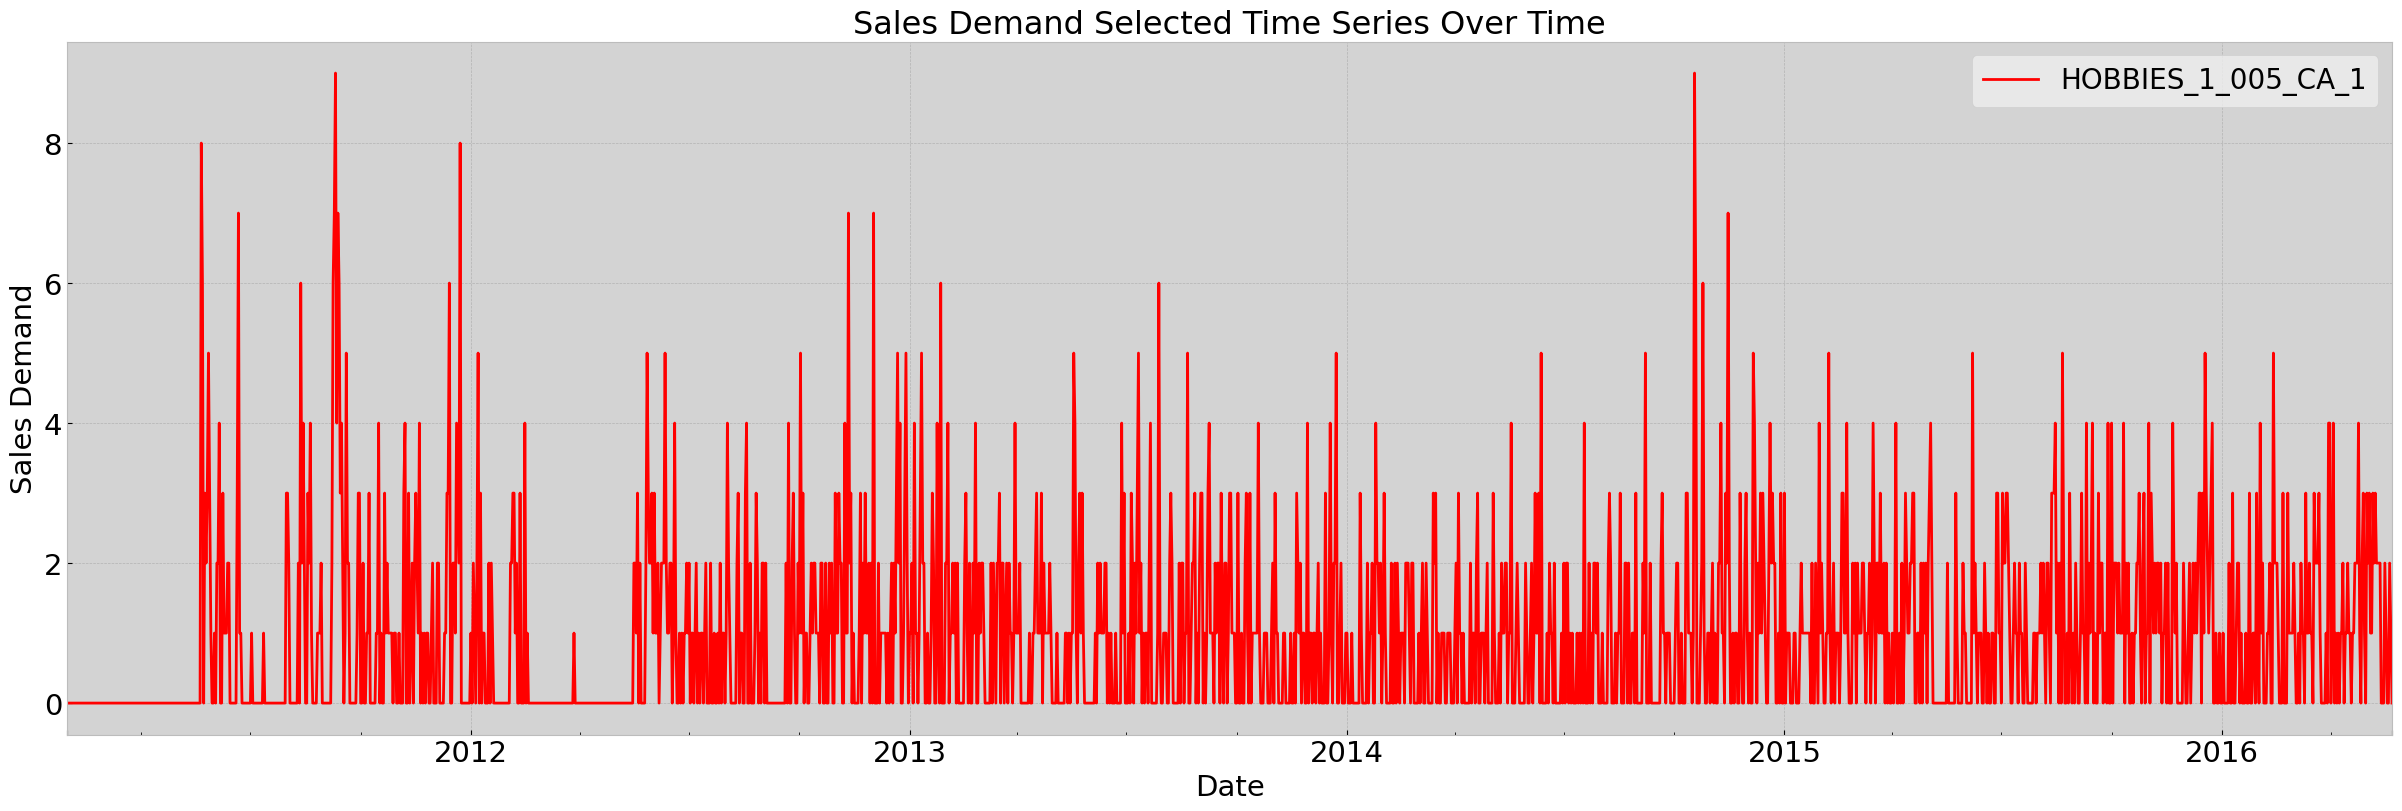

In [6]:
#Select arbitrary index and plot the time series
index = 4
y = pd.DataFrame(data_frame.iloc[:,index])
y = pd.DataFrame(y).set_index([dates_list])
TS_selected = y 
y.index = pd.to_datetime(y.index)
ax = y.plot(figsize=(30, 9),color='red')
ax.set_facecolor('lightgrey')
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.legend(fontsize=20)
plt.title(label = 'Sales Demand Selected Time Series Over Time',fontsize = 23)
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

In [7]:
# def gen_m5_covariates(calendar_df, sales_df):
#     # Assuming calendar_df is the calendar DataFrame and sales_df is the sales data DataFrame
#     num_covariates = 6  # Example: day of week, month, SNAP_CA, SNAP_TX, SNAP_WI, event, lag(1, 7, 14, 28, 365)
#     times = pd.to_datetime(calendar_df['date'])
#     covariates = np.zeros((len(times), num_covariates))
#     # Day of week and month as numerical values
#     covariates[:, 0] = times.dt.dayofweek
#     covariates[:, 1] = times.dt.month
#     # SNAP days for CA, TX, and WI
#     covariates[:, 2] = calendar_df['snap_CA']
#     covariates[:, 3] = calendar_df['snap_TX']
#     covariates[:, 4] = calendar_df['snap_WI']
#     # Event (simple binary indicator for this example)
#     covariates[:, 5] = calendar_df[['event_name_1', 'event_name_2']].notnull().any(axis=1).astype(int)

#     for index, i in enumerate(1,7,14,28,365):
#         print('Shifting:', i)
#         lag = sales_df['sales'].transform(lambda x: x.shift(i))
#         lag = lag.replace('nan', np.nan).fillna(0)
#         covariates[:, 6 + index] = lag

#     # Standardize covariates (optional depending on model requirements)
#     for i in range(num_covariates):
#         covariates[:, i] = (covariates[:, i] - covariates[:, i].mean()) / covariates[:, i].std()
#     return covariates

In [8]:
def gen_m5_covariates(calendar_df, sales_df):
    # Assuming calendar_df is the calendar DataFrame and sales_df is the sales data DataFrame
    num_covariates = 6  # Example: day of week, month, SNAP_CA, SNAP_TX, SNAP_WI, event
    times = pd.to_datetime(calendar_df['date'])
    covariates = np.zeros((len(times), num_covariates))
    # Day of week and month as numerical values
    covariates[:, 0] = times.dt.dayofweek
    covariates[:, 1] = times.dt.month
    # SNAP days for CA, TX, and WI
    covariates[:, 2] = calendar_df['snap_CA']
    covariates[:, 3] = calendar_df['snap_TX']
    covariates[:, 4] = calendar_df['snap_WI']
    # Event (simple binary indicator for this example)
    covariates[:, 5] = calendar_df[['event_name_1', 'event_name_2']].notnull().any(axis=1).astype(int)

    # Standardize covariates (optional depending on model requirements)
    for i in range(num_covariates):
        covariates[:, i] = (covariates[:, i] - covariates[:, i].mean()) / covariates[:, i].std()
    return covariates

In [9]:
covariates = gen_m5_covariates(calendar, sales)
train_data = data_frame[train_start:train_end].values
test_data = data_frame[test_start:test_end].values
data_start = (train_data!=0).argmax(axis=0) #find first nonzero value in each time series
total_time = data_frame.shape[0] #1941 (days)
num_series = data_frame.shape[1] #30490 (item_id)
covariates = covariates[:1941,:]

In [10]:
new_data_frame = data_frame.values
new_data_frame = new_data_frame[:, :, np.newaxis]
new_covariates = covariates[:,np.newaxis,:]
# Broadcast c to match the shape of b along the last axis
new_covariates_broadcasted = np.broadcast_to(new_covariates, (1941, 30490, 6))

# Concatenate b and c along the last axis to create the new array
dataset = np.concatenate((new_data_frame, new_covariates_broadcasted), axis=-1)

# Slice the array to get the desired shape (1491, 30490, 7) ##BUG? should be 1941?
dataset = dataset[:1941, :, :]
dataset = np.swapaxes(dataset,0,1)

print(dataset.shape)  # Output: (1491, 30490, 7) TODO: LOOK AT WHY DATA IS THIS SHAPE

(30490, 1941, 7)


In [11]:
dataset

array([[[ 0.        ,  0.99841426, -1.55900214, ..., -0.70199542,
         -0.70199542, -0.29941836],
        [ 0.        ,  1.49825603, -1.55900214, ..., -0.70199542,
         -0.70199542, -0.29941836],
        [ 0.        , -1.50079458, -1.55900214, ..., -0.70199542,
         -0.70199542, -0.29941836],
        ...,
        [ 3.        ,  0.49857249, -0.38804078, ..., -0.70199542,
         -0.70199542, -0.29941836],
        [ 0.        ,  0.99841426, -0.38804078, ..., -0.70199542,
         -0.70199542, -0.29941836],
        [ 1.        ,  1.49825603, -0.38804078, ..., -0.70199542,
         -0.70199542, -0.29941836]],

       [[ 0.        ,  0.99841426, -1.55900214, ..., -0.70199542,
         -0.70199542, -0.29941836],
        [ 0.        ,  1.49825603, -1.55900214, ..., -0.70199542,
         -0.70199542, -0.29941836],
        [ 0.        , -1.50079458, -1.55900214, ..., -0.70199542,
         -0.70199542, -0.29941836],
        ...,
        [ 0.        ,  0.49857249, -0.38804078, ..., -

In [12]:
def create_inout_sequences(input_data, pred_len, window_size, stride_size):
    train_X = []
    train_y = []
    L = len(input_data)
    # print('L:',L)
    block_num =  (L - window_size  - pred_len + 1) // stride_size
    # print('block_num:',block_num)

    for i in range(block_num):
        train_seq = input_data[i * stride_size : i * stride_size + window_size]
        train_label = input_data[i * stride_size : i * stride_size + window_size + pred_len,0]
        # print(train_label.shape)
        train_X.append(train_seq)
        train_y.append(train_label)

    # print(len(train_y))
    return train_X, train_y

def get_data(train_data, validation_data, test_data, pred_len, window_size, device, stride_size):

    train_X, train_y = create_inout_sequences(train_data, pred_len, window_size, stride_size)
    train_X = torch.FloatTensor(train_X)
    train_y = torch.FloatTensor(train_y)

    validation_X, validation_y = create_inout_sequences(validation_data, pred_len, window_size, stride_size)
    validation_X = torch.FloatTensor(validation_X)
    validation_y = torch.FloatTensor(validation_y)

    test_X, test_y = create_inout_sequences(test_data, pred_len, window_size, stride_size)
    test_X = torch.FloatTensor(test_X)
    test_y = torch.FloatTensor(test_y)

    return train_X.to(device),train_y.to(device),validation_X.to(device),validation_y.to(device), test_X.to(device),test_y.to(device)


In [13]:

total_len = 1941
# train_end = 1913
window_size = 196
pred_len = 28
# test_start = train_end - window_size
batch_size = 10
stride_size = 1
# print('test_start:',test_start)
# print(len(dataset[0]))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from sklearn.preprocessing import MinMaxScaler

class MinMaxScaler3D(MinMaxScaler):

    def fit_transform(self, X, y=None):
        x = np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2]))
        return np.reshape(super().fit_transform(x, y=y), newshape=X.shape)
    def transform(self, X):
        x = np.reshape(X, newshape=(-1, X.shape[-1]))  # Flatten all dimensions except the last one
        return np.reshape(super().transform(x), newshape=X.shape)


# input_data = dataset[0,:,:]
input_data = dataset[index,:,:]

non_zero_index = [i for i, x in enumerate(input_data[:,0]) if x][0]
input_data = input_data[non_zero_index:]


train_end = int(np.round(len(input_data) * 0.67))
test_start = train_end - window_size

train_data = input_data[:train_end]
validation_data = input_data[test_start:-pred_len-1]
test_data = input_data[-pred_len-window_size:]

# scaler_X = MinMaxScaler(feature_range=(0, 1))
# train_data = scaler_X.fit_transform(train_data)
# test_data = scaler_X.transform(test_data)
 
train_X, train_y, validation_X, validation_y, test_X, test_y = get_data(train_data, validation_data, test_data, pred_len, window_size, device, stride_size)


# scaler_X = MinMaxScaler3D()
# train_X = scaler_X.fit_transform(train_X)
# test_X = scaler_X.transform(test_X)

# scaler_y = StandardScaler()
# train_y = scaler_y.fit_transform(train_y)


# Define batch size
batch_size = 10

train_X = tensor_batch_norm(train_X)
validation_X = tensor_batch_norm(validation_X)
test_X = tensor_batch_norm(test_X)

print(train_X.shape)
print(train_y.shape)
print(validation_X.shape)
print(validation_y.shape)
print(test_X.shape)
print(test_y.shape)

# Convert NumPy arrays to PyTorch tensors
train_X_tensor = torch.tensor(train_X, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y, dtype=torch.float32)
validation_X_tensor = torch.tensor(validation_X, dtype=torch.float32)
validation_y_tensor = torch.tensor(validation_y, dtype=torch.float32)
test_X_tensor = torch.tensor(test_X, dtype=torch.float32)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32)

# Create TensorDataset and DataLoader for batching
train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = TensorDataset(validation_X_tensor, validation_y_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_X_tensor, test_y_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)




C:\Users\Milo\AppData\Local\Temp\ipykernel_5224\1398956048.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  train_X = torch.FloatTensor(train_X)


torch.Size([1002, 196, 7])
torch.Size([1002, 224])
torch.Size([548, 196, 7])
torch.Size([548, 224])
torch.Size([1, 196, 7])
torch.Size([1, 224])


C:\Users\Milo\AppData\Local\Temp\ipykernel_5224\4172345517.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_X_tensor = torch.tensor(train_X, dtype=torch.float32)
C:\Users\Milo\AppData\Local\Temp\ipykernel_5224\4172345517.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y_tensor = torch.tensor(train_y, dtype=torch.float32)
C:\Users\Milo\AppData\Local\Temp\ipykernel_5224\4172345517.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_X_tensor = torch.tensor(validation_X, dtype=torch.float32)
C:\Users\Milo\AppD

In [14]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
from matplotlib import pyplot

torch.manual_seed(0)
np.random.seed(0)


# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
          

# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=7, d_model=512, nhead=8, num_layers=6, dropout=0.2):
        super(TransformerModel, self).__init__()
        
        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 224)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -196, :])
        return x

model = TransformerModel().to(device)


In [15]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 100
early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(epochs):
    
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        optimizer.zero_grad()
        outputs = model(x_batch)

        # print(y_batch)
        # print(outputs)
        
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in validation_loader:
            x_batch, y_batch = batch
            # x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            # print(outputs)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break

    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")

Epoch 1/100, Validation Loss: 1.6390
Epoch 2/100, Validation Loss: 1.6371
Epoch 3/100, Validation Loss: 1.6241
Epoch 4/100, Validation Loss: 1.6046
Epoch 5/100, Validation Loss: 1.6046
Epoch 6/100, Validation Loss: 1.5855
Epoch 7/100, Validation Loss: 1.5826
Epoch 8/100, Validation Loss: 1.5899
Epoch 9/100, Validation Loss: 1.5804
Epoch 10/100, Validation Loss: 1.5643
Epoch 11/100, Validation Loss: 1.5619
Epoch 12/100, Validation Loss: 1.5597
Epoch 13/100, Validation Loss: 1.5675
Epoch 14/100, Validation Loss: 1.5503
Epoch 15/100, Validation Loss: 1.5543
Epoch 16/100, Validation Loss: 1.5472
Epoch 17/100, Validation Loss: 1.5640
Epoch 18/100, Validation Loss: 1.5607
Epoch 19/100, Validation Loss: 1.5608
Epoch 00020: reducing learning rate of group 0 to 5.0000e-05.
Epoch 20/100, Validation Loss: 1.5580
Early stopping!


In [16]:
# Evaluation
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        print(outputs)
        predictions.extend(outputs.squeeze().tolist())
    
print(len(predictions))

# rmse = np.sqrt(np.mean((scaler.inverse_transform(np.array(predictions).reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))**2))
# print(f"Score (RMSE): {rmse:.4f}")

tensor([[0.2429, 0.5914, 0.9872, 0.6916, 1.4093, 1.4640, 1.5453, 0.9872, 0.8895,
         0.9750, 0.7814, 0.9920, 1.4736, 1.1023, 1.1405, 0.8232, 1.1617, 0.9110,
         1.1065, 1.5397, 1.2442, 0.5350, 0.4948, 0.8005, 0.7927, 1.1573, 1.5267,
         1.1761, 0.7595, 1.1703, 1.2250, 0.9787, 1.4161, 1.6367, 1.1746, 1.0737,
         0.6480, 1.5282, 0.9612, 1.2678, 1.6272, 1.2667, 1.3949, 1.2766, 1.2586,
         1.0025, 1.3472, 1.5000, 1.3182, 0.9747, 0.7972, 1.0954, 0.9433, 1.0675,
         1.2010, 1.4421, 0.5483, 0.7386, 0.8294, 0.7512, 1.1336, 1.7390, 1.4130,
         0.9482, 0.8533, 0.9609, 1.1147, 1.0285, 1.8581, 1.5792, 1.0041, 1.1376,
         0.9974, 1.1636, 1.1622, 1.6223, 1.3206, 0.7735, 0.8266, 1.2234, 0.6834,
         1.2940, 1.3251, 1.0648, 0.8312, 0.7472, 0.7712, 0.8982, 1.4810, 1.4538,
         1.5022, 0.8552, 0.5474, 0.9104, 0.6700, 0.9514, 1.3441, 1.1445, 1.2420,
         0.7601, 1.1711, 0.6278, 1.2619, 1.5130, 1.4124, 0.9264, 1.2464, 1.2572,
         0.8805, 0.9804, 1.3

224


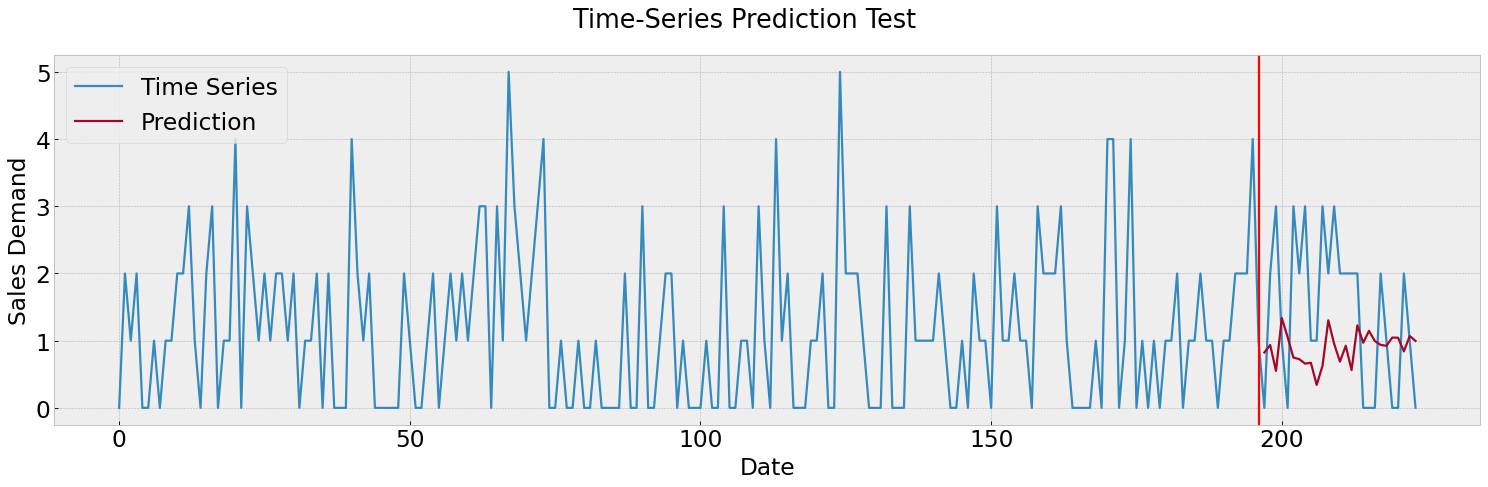

In [17]:
figure(num=None, figsize=(23, 6), dpi=80, facecolor='w', edgecolor='k')

pred_array = np.zeros(224)  
pred_array[pred_array!=1] = np.NaN
pred_array[197:] = predictions[197:]
print(len(pred_array))
plt.plot(test_y[0])
plt.plot(pred_array)
plt.legend(['Time Series','Prediction'],fontsize = 21,loc="upper left")
plt.suptitle('Time-Series Prediction Test',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.axvline(x = 196, color = 'r', label = 'axvline - full height')

In [18]:
np.sqrt(((test_y[0].numpy()[-28:]- predictions[-28:]) ** 2).mean())

1.2905569448269198